In [1]:
import pandas as pd
import numpy as np
import csv
import json
import random
import matplotlib.pyplot as plt

In [2]:
train_file = '/root/data/S10.json'
with open(train_file) as data_file:
    train_anns=json.load(data_file)

In [3]:
train_anns['annotations'][:1]

[{'sequence_level_annotation': True,
  'id': '4dec24e3-955a-11e9-8c32-000d3a198845',
  'category_id': 0,
  'seq_id': 'SER_S10#B03#1#1',
  'season': 'S10',
  'datetime': '2015-01-16 11:31:41',
  'subject_id': 'ASG001y55b',
  'count': nan,
  'standing': nan,
  'resting': nan,
  'moving': nan,
  'interacting': nan,
  'young_present': nan,
  'image_id': 'S10/B03/B03_R1/S10_B03_R1_IMAG0001',
  'location': 'B03'}]

In [4]:
img_5=[]
for i in train_anns['annotations']:
    if i['category_id'] == 5:
        img_5.append(i['image_id']+'.JPG')
img_5_1w = random.sample(img_5, 1300)

In [5]:
img_21=[]
for i in train_anns['annotations']:
    if i['category_id'] == 21:
        img_21.append(i['image_id']+'.JPG')
img_21_1w = random.sample(img_21,1300)

In [6]:
img_list = img_5_1w+img_21_1w

In [7]:
len(img_list)

2600

In [8]:
img_list[:2]

['S10/H05/H05_R1/S10_H05_R1_IMAG0191.JPG',
 'S10/P10/P10_R2/S10_P10_R2_IMAG1994.JPG']

In [9]:
label_dict = {}
for i in train_anns['annotations']:
    i_new = i['image_id'] + '.JPG'
    if i_new in img_list:
        label_dict[i_new]=i['category_id']

In [10]:
len(label_dict)

2600

In [39]:
df = pd.DataFrame.from_dict(label_dict,orient='index',columns=['label'])
df = df.reset_index().rename(columns={'index':'image_id'})
df.head()

,image_id,label
0,S10/B03/B03_R1/S10_B03_R1_IMAG0982.JPG,5
1,S10/B03/B03_R1/S10_B03_R1_IMAG0987.JPG,5
2,S10/B03/B03_R1/S10_B03_R1_IMAG1003.JPG,5
3,S10/B03/B03_R1/S10_B03_R1_IMAG1042.JPG,5
4,S10/B03/B03_R1/S10_B03_R1_IMAG1044.JPG,5


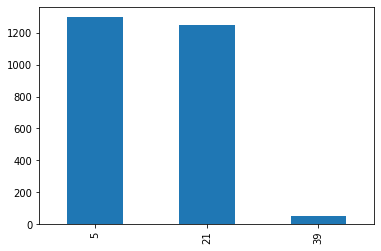

In [40]:
df['label'].value_counts().plot.bar()
plt.show()

In [50]:
df.label.unique()

array([ 5, 21, 39])

In [59]:
df.loc[df.label == 39, 'label']=21

In [60]:
df.label.unique()

array([ 5, 21])

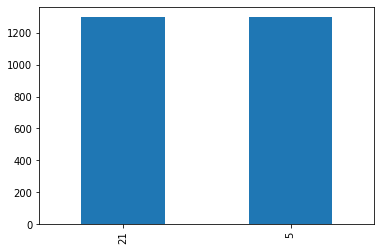

In [61]:
df['label'].value_counts().plot.bar()
plt.show()

### Modeling

In [17]:
import tensorflow as tf
import os
import random
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img
from shutil import copyfile
import numpy as np
import pandas  as pd
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

import os
import json

import numpy as np
import pandas as pd
import keras
from keras.callbacks import Callback
from keras.datasets import cifar10
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score
from sklearn.model_selection import train_test_split

Using TensorFlow backend.


In [18]:
IMAGE_WIDTH=128
IMAGE_HEIGHT=128
IMAGE_SIZE=(IMAGE_WIDTH, IMAGE_HEIGHT)
IMAGE_CHANNELS=3

In [19]:
class Metrics(Callback):
    def on_train_begin(self, logs={}):
        self.val_f1s = []
        self.val_recalls = []
        self.val_precisions = []

    def on_epoch_end(self, epoch, logs={}):
        X_val, y_val = self.validation_data[:2]
        y_pred = self.model.predict(X_val)

        y_pred_cat = keras.utils.to_categorical(
            y_pred.argmax(axis=1),
            num_classes=num_classes
        )

        _val_f1 = f1_score(y_val, y_pred_cat, average='macro')
        _val_recall = recall_score(y_val, y_pred_cat, average='macro')
        _val_precision = precision_score(y_val, y_pred_cat, average='macro')

        self.val_f1s.append(_val_f1)
        self.val_recalls.append(_val_recall)
        self.val_precisions.append(_val_precision)

        print((f"val_f1: {_val_f1:.4f}"
               f" ? val_precision: {_val_precision:.4f}"
               f" ? val_recall: {_val_recall:.4f}"))

        return


In [20]:
batch_size = 64
num_classes = 2
epochs = 30
val_split = 0.1
save_dir = os.path.join(os.getcwd(), 'models')
model_name = 'keras_cnn_model.h5'

In [21]:
model = Sequential()
model.add(Conv2D(32, (3, 3), padding='same',
                 input_shape=(128,128,3)))
model.add(Activation('relu'))
model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(2))
model.add(Activation('softmax'))






Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [22]:
f1_metrics = Metrics()

model.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

hist = model.fit(
    x_train, 
    y_train,
    batch_size=batch_size,
    epochs=epochs,
    callbacks=[f1_metrics],
    validation_split=val_split,
    shuffle=True
)

NameError: name 'x_train' is not defined

In [64]:
df['label']=df['label'].replace({5:'zebra',21:'lionfemale'})

In [65]:
df.head()

,image_id,label
0,S10/B03/B03_R1/S10_B03_R1_IMAG0982.JPG,zebra
1,S10/B03/B03_R1/S10_B03_R1_IMAG0987.JPG,zebra
2,S10/B03/B03_R1/S10_B03_R1_IMAG1003.JPG,zebra
3,S10/B03/B03_R1/S10_B03_R1_IMAG1042.JPG,zebra
4,S10/B03/B03_R1/S10_B03_R1_IMAG1044.JPG,zebra


In [66]:
train_df, validate_df = train_test_split(df, test_size=0.30, random_state=523)
train_df = train_df.reset_index(drop=True)
validate_df = validate_df.reset_index(drop=True)

In [67]:
len(train_df)

1820

In [68]:
len(validate_df)

780

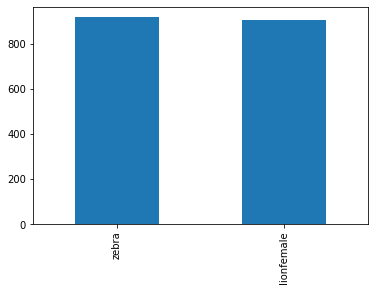

In [69]:
train_df['label'].value_counts().plot.bar()

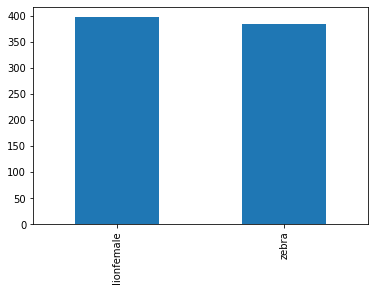

In [70]:
validate_df['label'].value_counts().plot.bar()

In [71]:
total_train = train_df.shape[0]
total_validate = validate_df.shape[0]
batch_size = 64

In [72]:
type(train_df['image_id'][:1])

pandas.core.series.Series

In [73]:
train_datagen = ImageDataGenerator(
    rotation_range=15,
    rescale=1./255,
    shear_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1
)

In [74]:
train_generator = train_datagen.flow_from_dataframe(
    train_df,
    "/root/data/",
    x_col='image_id',
    y_col='label',
    target_size=(128,128),
    class_mode="categorical",
    batch_size=10
)

Found 1810 validated image filenames belonging to 2 classes.


/root/anaconda3/lib/python3.7/site-packages/keras_preprocessing/image/dataframe_iterator.py:273: UserWarning: Found 10 invalid image filename(s) in x_col="image_id". These filename(s) will be ignored.
  .format(n_invalid, x_col)


In [75]:
validation_datagen = ImageDataGenerator(rescale=1./255)
validation_generator = validation_datagen.flow_from_dataframe(
    validate_df, 
    "/root/data/", 
    x_col='image_id',
    y_col='label',
    target_size=(128,128),
    class_mode='categorical',
    batch_size=batch_size
)


Found 771 validated image filenames belonging to 2 classes.


/root/anaconda3/lib/python3.7/site-packages/keras_preprocessing/image/dataframe_iterator.py:273: UserWarning: Found 9 invalid image filename(s) in x_col="image_id". These filename(s) will be ignored.
  .format(n_invalid, x_col)


In [76]:
train_df.describe()

,image_id,label
count,1820,1820
unique,1820,2
top,S10/K09/K09_R3/S10_K09_R3_IMAG0878.JPG,zebra
freq,1,917


In [79]:
# check unique
#p_new = df.groupby(['image_id']).size()
#p_new

In [82]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

In [83]:
earlystop = EarlyStopping(patience=10)

In [84]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', 
                                            patience=2, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)

In [86]:
callbacks = [earlystop, learning_rate_reduction]

In [87]:
epochs=30
history = model.fit_generator(
    train_generator, 
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=total_validate//batch_size,
    steps_per_epoch=total_train//batch_size,
    callbacks=callbacks
)

Epoch 1/30
28/28 [==============================] - 102s 4s/step - loss: 0.6463 - acc: 0.6107 - val_loss: 0.5974 - val_acc: 0.7129
Epoch 2/30
28/28 [==============================] - 71s 3s/step - loss: 0.5845 - acc: 0.7286 - val_loss: 0.4659 - val_acc: 0.7935
Epoch 3/30
28/28 [==============================] - 70s 3s/step - loss: 0.6427 - acc: 0.7214 - val_loss: 0.6132 - val_acc: 0.7199
Epoch 4/30
28/28 [==============================] - 70s 2s/step - loss: 0.6390 - acc: 0.6250 - val_loss: 0.4985 - val_acc: 0.7680

Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
Epoch 5/30
28/28 [==============================] - 76s 3s/step - loss: 0.5154 - acc: 0.7393 - val_loss: 0.4517 - val_acc: 0.8073
Epoch 6/30
28/28 [==============================] - 70s 2s/step - loss: 0.5209 - acc: 0.7429 - val_loss: 0.4383 - val_acc: 0.8020
Epoch 7/30
28/28 [==============================] - 70s 2s/step - loss: 0.4969 - acc: 0.8071 - val_loss: 0.4991 - val_acc: 0.7793

Epoch 0

### try deep network

https://www.jianshu.com/p/946bdebeb6fc

In [90]:
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D, ZeroPadding2D, GlobalMaxPooling2D
import keras
from keras.datasets import cifar10
import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt
from keras.preprocessing.image import ImageDataGenerator


In [97]:
def quality_classify_model():
    model = Sequential()

    model.add(Conv2D(32, (3, 3), padding='same', input_shape=(128,128,3)))
    model.add(Activation('relu'))
    model.add(Conv2D(32, (3, 3), padding='same'))
    model.add(Activation('relu'))
    model.add(Conv2D(32, (3, 3), padding='same'))
    model.add(Activation('relu'))
    model.add(Conv2D(48, (3, 3), padding='same'))
    model.add(Activation('relu'))
    model.add(Conv2D(48, (3, 3), padding='same'))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Conv2D(80, (3, 3), padding='same'))
    
    model.add(Activation('relu'))
    model.add(Conv2D(80, (3, 3), padding='same'))
    model.add(Activation('relu'))
    model.add(Conv2D(80, (3, 3), padding='same'))
    model.add(Activation('relu'))
    model.add(Conv2D(80, (3, 3), padding='same'))
    model.add(Activation('relu'))
    model.add(Conv2D(80, (3, 3), padding='same'))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    
    model.add(Conv2D(128, (3, 3), padding='same'))
    model.add(Activation('relu'))
    model.add(Conv2D(128, (3, 3), padding='same'))
    model.add(Activation('relu'))
    model.add(Conv2D(128, (3, 3), padding='same'))
    model.add(Activation('relu'))
    model.add(Conv2D(128, (3, 3), padding='same'))
    model.add(Activation('relu'))
    model.add(Conv2D(128, (3, 3), padding='same'))
    model.add(Activation('relu'))
    model.add(GlobalMaxPooling2D())
    model.add(Dropout(0.25))

    model.add(Dense(500))
    model.add(Activation('relu'))
    model.add(Dropout(0.25))
    model.add(Dense(2))
    model.add(Activation('softmax'))
    # model.summary () # ????????

    opt = keras.optimizers.Adam(lr=0.0001)
    model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

    return model

In [100]:
classes_num =2
batch_size = 64
epochs = 30

In [101]:
quality_classify_model()

In [102]:
history = model.fit_generator(
    train_generator, 
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=total_validate//batch_size,
    steps_per_epoch=total_train//batch_size,
    callbacks=callbacks
)

Epoch 1/30
28/28 [==============================] - 72s 3s/step - loss: 0.4352 - acc: 0.8143 - val_loss: 0.4915 - val_acc: 0.7864
Epoch 2/30
28/28 [==============================] - 70s 2s/step - loss: 0.4173 - acc: 0.8179 - val_loss: 0.4803 - val_acc: 0.7935
Epoch 3/30
28/28 [==============================] - 70s 2s/step - loss: 0.4013 - acc: 0.8143 - val_loss: 0.4926 - val_acc: 0.7907
Epoch 4/30
28/28 [==============================] - 69s 2s/step - loss: 0.4750 - acc: 0.7821 - val_loss: 0.4877 - val_acc: 0.7907
Epoch 5/30
28/28 [==============================] - 74s 3s/step - loss: 0.3961 - acc: 0.8143 - val_loss: 0.4800 - val_acc: 0.7956
Epoch 6/30
28/28 [==============================] - 70s 2s/step - loss: 0.4864 - acc: 0.7750 - val_loss: 0.4712 - val_acc: 0.8020
Epoch 7/30
28/28 [==============================] - 70s 3s/step - loss: 0.4449 - acc: 0.8286 - val_loss: 0.4632 - val_acc: 0.7963
Epoch 8/30
28/28 [==============================] - 69s 2s/step - loss: 0.4369 - acc: 0.81

/root/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  del sys.path[0]


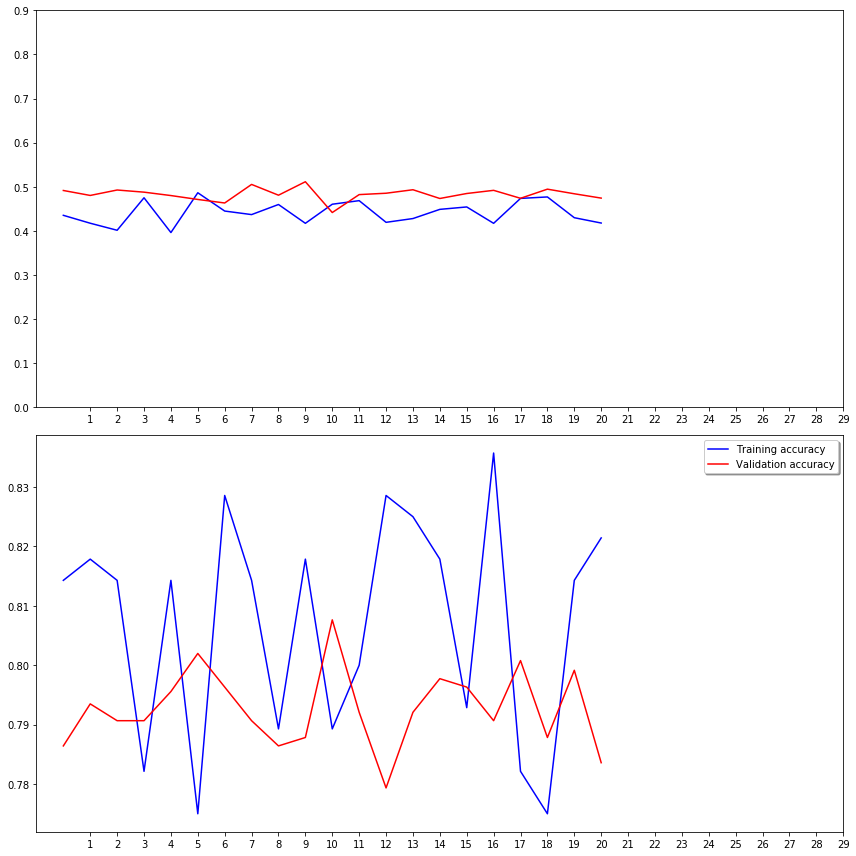

In [103]:

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12))
ax1.plot(history.history['loss'], color='b', label="Training loss")
ax1.plot(history.history['val_loss'], color='r', label="validation loss")
ax1.set_xticks(np.arange(1, epochs, 1))
ax1.set_yticks(np.arange(0, 1, 0.1))

ax2.plot(history.history['acc'], color='b', label="Training accuracy")
ax2.plot(history.history['val_acc'], color='r',label="Validation accuracy")
ax2.set_xticks(np.arange(1, epochs, 1))

legend = plt.legend(loc='best', shadow=True)
plt.tight_layout()
plt.show()

### transfer learning vgg16

prepare the X_train, Y_train

In [132]:
import os,sys
import numpy as np
import scipy
from scipy import ndimage
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions
from PIL import Image
import random

In [117]:
imglist=train_df['image_id'].tolist()

In [126]:
imglist_test = validate_df['image_id'].tolist()

In [127]:
type(imglist)

list

In [128]:
type(imglist_test)

list

In [120]:
X_train = np.empty((len(imglist),128,128,3))

In [122]:
Y_train = np.empty((len(imglist),2))

In [123]:
X_train.shape

(1820, 128, 128, 3)

In [125]:
Y_train.shape

(1820, 2)

In [129]:
path = '/root/data/'

In [136]:
count=0
nonelist=[]
for img_name in imglist:
    img_path = path + img_name
    try:
        img = image.load_img(img_path, target_size=(128,128))
        img = image.img_to_array(img)/255.0
        X_train[count]=img
        Y_train[count]=np.array((1,0))
        count+=1
    except:
        nonelist.append(img_path)

In [138]:
Y_train[:2]

array([[1., 0.],
       [1., 0.]])

In [140]:
X_train[:2]

array([[[[0.21176471, 0.47058824, 0.80784315],
         [0.16862746, 0.4627451 , 0.78039217],
         [0.19215687, 0.48627451, 0.80392158],
         ...,
         [0.32549021, 0.56470591, 0.9137255 ],
         [0.31764707, 0.57254905, 0.90196079],
         [0.32549021, 0.58431375, 0.92156863]],

        [[0.19215687, 0.49803922, 0.79215688],
         [0.20392157, 0.45490196, 0.80000001],
         [0.22352941, 0.48235294, 0.81176472],
         ...,
         [0.29019609, 0.5529412 , 0.90196079],
         [0.30588236, 0.58039218, 0.9137255 ],
         [0.29411766, 0.60392159, 0.9137255 ]],

        [[0.2       , 0.47058824, 0.77254903],
         [0.21568628, 0.48627451, 0.78823531],
         [0.2       , 0.48627451, 0.79607844],
         ...,
         [0.33725491, 0.57647061, 0.90196079],
         [0.3137255 , 0.55686277, 0.89803922],
         [0.30980393, 0.56862748, 0.90980393]],

        ...,

        [[0.86274511, 0.86274511, 0.86274511],
         [0.86274511, 0.86274511, 0.86274511]